<a href="https://colab.research.google.com/github/Jannatu37/machine-learning-/blob/main/Transfer_Learning_and_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning** and **Hyperparameter Tuning** are two essential concepts in modern machine learning. Transfer Learning involves leveraging a pre-trained model on one task and adapting it for a different but related task, significantly reducing the time and data needed to train a model. Hyperparameter Tuning, on the other hand, focuses on optimizing the settings that govern how a model learns, such as learning rate, batch size, and the number of epochs, to improve performance. Together, these techniques help build more efficient and effective machine learning models.

# Initialization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/Aa/jellyfish'
img_size = (224, 224)
batch_size = 32
seed = 42

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 1889 files belonging to 7 classes.


# Train-test Split

In [7]:
# Determine the size of the full dataset
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

# Calculate the number of batches for training and validation
train_size = int(0.8 * dataset_size)

# Split the dataset
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

# Removing Imbalance

In [8]:
import tensorflow as tf
from collections import defaultdict

# Step 1: Count examples per class
class_counts = defaultdict(int)

for _, label_batch in train_ds: # Rename 'label' to 'label_batch' for clarity
    # Iterate through each individual label in the batch
    for label in label_batch.numpy():
        class_counts[int(label)] += 1

print("Class counts:", class_counts)

Class counts: defaultdict(<class 'int'>, {1: 790, 3: 125, 0: 126, 4: 133, 6: 123, 2: 121, 5: 118})


In [9]:
# Step 2: Find the maximum class size
max_count = max(class_counts.values())

In [10]:
# Step 3: Split dataset by class into separate lists of tensors
class_images = defaultdict(list)
class_labels = defaultdict(list)

# Iterate through the dataset in batches
for image_batch, label_batch in train_ds:
    # Iterate through each image and label within the current batch
    for image, label in zip(tf.unstack(image_batch), tf.unstack(label_batch)):
        # Explicitly cast image to float32 and label to int64
        class_images[int(label.numpy())].append(tf.cast(image, tf.float32))
        class_labels[int(label.numpy())].append(tf.cast(label, tf.int64))

In [11]:
# Step 4: Convert to tf.data.Dataset and oversample
balanced_datasets = []
for label in class_counts.keys():
    # Get the lists of images and labels for this class
    items_images = class_images[label]
    items_labels = class_labels[label]

    # Ensure both lists are converted to tensors or numpy arrays for from_tensor_slices
    # Converting to NumPy arrays is often safer with from_tensor_slices for lists of tensors
    items_images_np = tf.stack(items_images).numpy()
    items_labels_np = tf.stack(items_labels).numpy()

    # Create the dataset from separate arrays
    ds = tf.data.Dataset.from_tensor_slices((items_images_np, items_labels_np))

    # Continue with oversampling as before
    repeats = max_count // len(items_images)
    remainder = max_count % len(items_images)

    # Repeat whole dataset and add a few more
    oversampled_ds = ds.repeat(repeats)
    oversampled_ds = oversampled_ds.concatenate(ds.take(remainder))
    balanced_datasets.append(oversampled_ds)

In [12]:
# Step 5: Combine and shuffle
balanced_train_ds = balanced_datasets[0]
for ds in balanced_datasets[1:]:
    balanced_train_ds = balanced_train_ds.concatenate(ds)

shuffle_buffer_size = tf.data.experimental.cardinality(balanced_train_ds).numpy()

balanced_train_ds = balanced_train_ds.shuffle(shuffle_buffer_size).batch(32).prefetch(tf.data.AUTOTUNE)


# Data Augmentation

In [13]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [14]:
# Apply data augmentation to the balanced training dataset
augmented_train_ds = balanced_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
augmented_train_ds = augmented_train_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
# Show number of samples in augmented training set
augmented_class_counts = defaultdict(int)

# Iterate through the augmented_train_ds in batches
for _, label_batch in augmented_train_ds:
    for label in label_batch.numpy():
        augmented_class_counts[int(label)] += 1

print("Class counts in augmented_train_ds:", augmented_class_counts)

Class counts in augmented_train_ds: defaultdict(<class 'int'>, {3: 790, 1: 790, 6: 790, 0: 790, 5: 790, 4: 790, 2: 790})


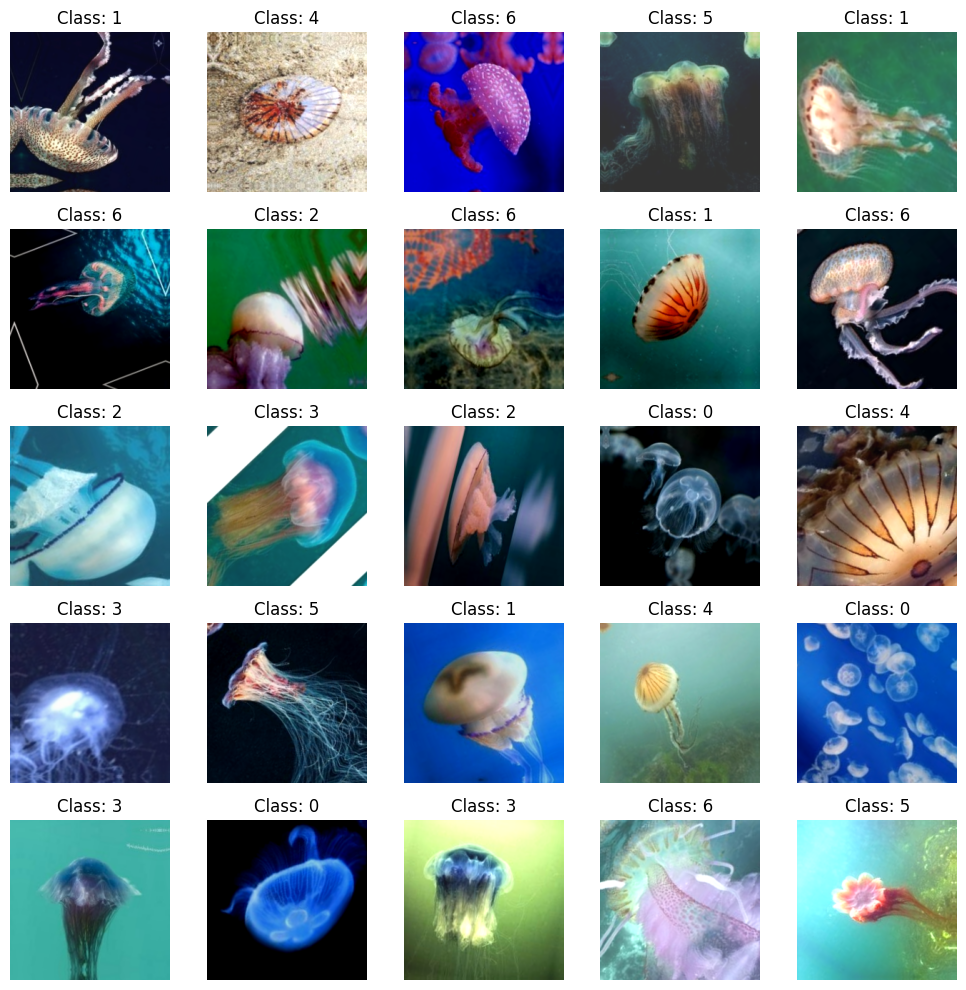

In [16]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(augmented_train_ds))

num_images_to_display = 25

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]
  ax.imshow(image_batch[i].numpy().astype("uint8"))
  ax.set_title(f"Class: {label_batch[i].numpy()}")
  ax.axis("off")

plt.tight_layout()
plt.show()


# Feature Extraction using Transfer Learning Model

In [17]:
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model

# Load the ResNet50 model without the top (classification) layers
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Add a Global Average Pooling layer
x = GlobalAveragePooling2D()(resnet50.output)

# Create the feature extraction model using ResNet50
feature_extractor_resnet = Model(inputs=resnet50.input, outputs=x)

# Function to extract features
def extract_features(dataset, feature_model):
  features = []
  labels = []
  # Iterate through the dataset in batches
  for images, batch_labels in dataset:
    batch_features = feature_model.predict(images, verbose=0)
    features.extend(batch_features)
    labels.extend(batch_labels.numpy())
  return np.array(features), np.array(labels)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [18]:
# Extract features from augmented training set using ResNet50
print("Extracting features from the augmented training set using ResNet50...")
X_train, y_train = extract_features(augmented_train_ds, feature_extractor_resnet)
print("Features extracted from augmented training set using ResNet50.")

# Extract features from test set using ResNet50
print("Extracting features from the test set using ResNet50...")
X_test, y_test = extract_features(test_ds, feature_extractor_resnet)
print("Features extracted from test set using ResNet50.")

X_train

Extracting features from the augmented training set using ResNet50...
Features extracted from augmented training set using ResNet50.
Extracting features from the test set using ResNet50...
Features extracted from test set using ResNet50.


array([[3.0052965 , 0.06458554, 0.1980402 , ..., 2.1364002 , 0.10396422,
        0.        ],
       [0.94316524, 2.6757183 , 0.        , ..., 2.7983863 , 2.110028  ,
        1.0463783 ],
       [1.7396173 , 1.2716454 , 0.22140966, ..., 0.5150278 , 0.9659188 ,
        0.        ],
       ...,
       [2.3016737 , 0.06741649, 0.        , ..., 0.        , 0.08579231,
        0.        ],
       [1.4315709 , 1.2532624 , 0.15698408, ..., 0.2747988 , 0.13986519,
        1.2890581 ],
       [1.1379739 , 0.5856853 , 0.        , ..., 0.43588376, 1.6585354 ,
        1.8379513 ]], dtype=float32)

In [19]:
X_train.shape

(5530, 2048)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
test_predictions = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, test_predictions)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
class_names = full_ds.class_names
print(classification_report(y_test, test_predictions, target_names=class_names))

Accuracy: 0.4448

Classification Report:
                         precision    recall  f1-score   support

         Moon_jellyfish       0.44      0.96      0.60        27
       Train_Test_Valid       0.57      0.04      0.08       191
       barrel_jellyfish       0.54      1.00      0.70        29
         blue_jellyfish       0.45      0.88      0.60        26
      compass_jellyfish       0.48      0.81      0.60        36
   lions_mane_jellyfish       0.35      0.92      0.51        25
mauve_stinger_jellyfish       0.38      1.00      0.55        19

               accuracy                           0.44       353
              macro avg       0.46      0.80      0.52       353
           weighted avg       0.52      0.44      0.32       353



# Hyperparameter Tuning using Optuna

In [ ]:
try:
  import optuna
except:
  !pip install optuna
  import optuna

def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create and train the Random Forest Classifier with suggested hyperparameters
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    rf_classifier.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_predictions = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, test_predictions)

    # Return the metric to minimize or maximize (accuracy in this case)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction='maximize') # We want to maximize accuracy

# Run the optimization
study.optimize(objective, n_trials=150) # Run 100 trials

# Print the best hyperparameters and the corresponding best accuracy
print("Best hyperparameters found by Optuna:")
print(study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-07-07 22:19:55,014] A new study created in memory with name: no-name-5aedc793-956c-4cee-a2e2-c357ba17b15a
[I 2025-07-07 22:21:12,085] Trial 0 finished with value: 0.43342776203966005 and parameters: {'n_estimators': 404, 'max_depth': 38, 'min_samples_split': 18, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.43342776203966005.
[I 2025-07-07 22:21:48,789] Trial 1 finished with value: 0.43626062322946174 and parameters: {'n_estimators': 87, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 1 with value: 0.43626062322946174.
[I 2025-07-07 22:24:08,591] Trial 2 finished with value: 0.42209631728045327 and parameters: {'n_estimators': 445, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 1 with value: 0.43626062322946174.
[I 2025-07-07 22:25:41,800] Trial 3 finished with value: 0.43059490084985835 and parameters: {'n_estimators': 322, 'max_depth': 4